In [1]:
import keras
from keras.models import load_model
from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import os, sys
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
sys.path.insert(0,'../lib')
from train import get_features

Using TensorFlow backend.


In [2]:
Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel outputDir")

options = Option(
    inputModel = 'KERAS_gru_model_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_gru.yml',
    jsonModel = 'KERAS_gru_model.json',
    outputDir = '/output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader=yaml.FullLoader)
yamlConfig

Loading configuration from train_config_gru.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'gru_model',
 'KerasModelRetrain': 'gru_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'L1RegR': 0.001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 20}

In [3]:
json_file = open(options.jsonModel, 'r')
model = model_from_json(json_file.read())
json_file.close()

#model.load_weights(options.inputModel)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 6)]           0         
_________________________________________________________________
gru_selu (GRU)               (None, 20)                1680      
_________________________________________________________________
dense_relu (Dense)           (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 105       
Total params: 2,205
Trainable params: 2,205
Non-trainable params: 0
_________________________________________________________________


In [4]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

../lib\train.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  h5File = h5py.File(options.inputFile)


(5119909,)
('j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_index', '

In [5]:
from callbacks import all_callbacks
adam = Adam(lr=0.0001)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

callbacks=all_callbacks(stop_patience=1000, 
                        lr_factor=0.5,
                        lr_patience=10,
                        lr_epsilon=0.000001, 
                        lr_cooldown=2, 
                        lr_minimum=0.0000001,
                        outputDir=options.outputDir)

C:\Users\45148\anaconda3\envs\EPE_ML_TF2_GPU\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [6]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100,
                    validation_split = 0.25, shuffle = True, callbacks = None)

Epoch 1/100
15/15 [==============================] - 1s 59ms/step - loss: 1.6802 - accuracy: 0.5092 - val_loss: 1.6649 - val_accuracy: 0.5821
Epoch 2/100
15/15 [==============================] - 1s 41ms/step - loss: 1.6534 - accuracy: 0.5677 - val_loss: 1.6367 - val_accuracy: 0.6504
Epoch 3/100
15/15 [==============================] - 1s 41ms/step - loss: 1.6255 - accuracy: 0.6225 - val_loss: 1.6084 - val_accuracy: 0.7056
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 1.5978 - accuracy: 0.6677 - val_loss: 1.5798 - val_accuracy: 0.7413
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 1.5671 - accuracy: 0.7090 - val_loss: 1.5504 - val_accuracy: 0.7663
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 1.5379 - accuracy: 0.7338 - val_loss: 1.5201 - val_accuracy: 0.7778
Epoch 7/100
15/15 [==============================] - 1s 43ms/step - loss: 1.5081 - accuracy: 0.7504 - val_loss: 1.4888 - val_accuracy: 0.7862
Epoch 

15/15 [==============================] - 1s 46ms/step - loss: 0.3711 - accuracy: 0.8882 - val_loss: 0.3662 - val_accuracy: 0.8882
Epoch 59/100
15/15 [==============================] - 1s 40ms/step - loss: 0.3686 - accuracy: 0.8882 - val_loss: 0.3635 - val_accuracy: 0.8890
Epoch 60/100
15/15 [==============================] - 1s 44ms/step - loss: 0.3657 - accuracy: 0.8901 - val_loss: 0.3608 - val_accuracy: 0.8904
Epoch 61/100
15/15 [==============================] - 1s 45ms/step - loss: 0.3632 - accuracy: 0.8907 - val_loss: 0.3581 - val_accuracy: 0.8906
Epoch 62/100
15/15 [==============================] - 1s 46ms/step - loss: 0.3604 - accuracy: 0.8911 - val_loss: 0.3554 - val_accuracy: 0.8912
Epoch 63/100
15/15 [==============================] - 1s 52ms/step - loss: 0.3577 - accuracy: 0.8921 - val_loss: 0.3528 - val_accuracy: 0.8918
Epoch 64/100
15/15 [==============================] - 1s 49ms/step - loss: 0.3543 - accuracy: 0.8938 - val_loss: 0.3501 - val_accuracy: 0.8922
Epoch 65/100

In [7]:
model.save('GRU') #Saves to local directory;

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: GRU\assets


In [8]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

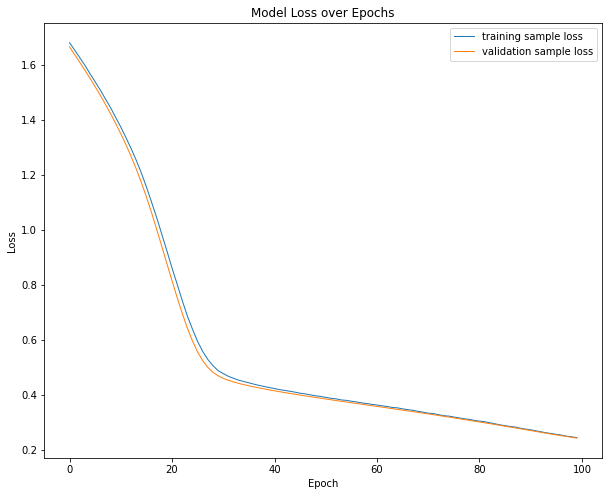

In [9]:
learningCurve(history)

In [10]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.semilogy()
    plt.figtext(0.25, 0.90,'GRU ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

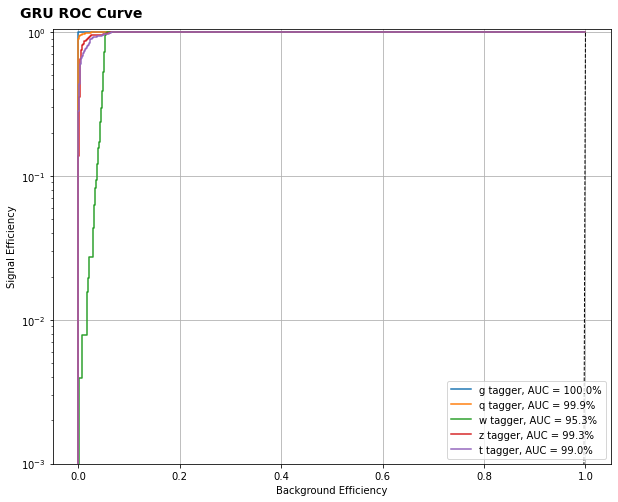

In [11]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='GRU')